# Loan Approval Predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### The problem will be explored in the following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Clean and Split – handling missing values, then splitting the dataset into training and test sets that are random and representative
3. Data Exploration – looking for patterns in the data
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making a predictive model on the data
6. Deployment - test api and deploy to the cloud

## 1. Hypothesis Generation
Some factors that may be important in determining loan approval are:
* Credit history and score
* Income
* Debt-to-income ratio
* Employment History
* Loan amount and term


## 2. Clean and Split
Tidying up, then splitting the dataset into training and test sets that are random and representative.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("../data/data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Discriminatory columns should be removed, these columns are:
* Gender - Using gender as a feature for loan approval decisions would violate the principle of equal opportunity and fair treatment (illegal)
* Married - Same reasoning as above, it is a violation of the Canadian Human Rights Act (CHRA) to use marital status as a factor in determining loan approvals.

In [2]:
discrim_cols = ['Gender', 'Married']

There are other columns that may be considered discriminatory if used as factors without clear definition as to how they impact the applicants ability to repay the loan. This sort of investigation is outside the scope of this project, and so the following columns will also not be considered by the model:
* Dependents - Discrimination on the basis of family status
* Education - Discrimination on the basis of race, since the racial inequality in Canadian educational opportunity is currently under scrutiny. 
* Property_area - This feature is too general, it opens up the potential for bias on the basis race, ethnic or national origin, family status, and other protected characteristics. Geographic location can be an important factor however, and this feature could be remedied by division into features more specifically applicable to loan repayment like property_value or property_market_growth.

In [3]:
potential_discrim_cols = ['Dependents', 'Education', 'Property_Area']

The remaining columns for analysis and modelling are:
* ApplicantIncome
* CoapplicantIncome
* LoanAmount
* Loan_Amount_Term
* Credit_History

In [4]:
features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

#### Cleaning

Handling missing values and setting proper dtypes

In [5]:
#Check for missing values
print(df['Loan_Status'].info())
print(df[features].info())

<class 'pandas.core.series.Series'>
RangeIndex: 614 entries, 0 to 613
Series name: Loan_Status
Non-Null Count  Dtype 
--------------  ----- 
614 non-null    object
dtypes: object(1)
memory usage: 4.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ApplicantIncome    614 non-null    int64  
 1   CoapplicantIncome  614 non-null    float64
 2   LoanAmount         592 non-null    float64
 3   Loan_Amount_Term   600 non-null    float64
 4   Credit_History     564 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 24.1 KB
None


<Axes: xlabel='LoanAmount', ylabel='Count'>

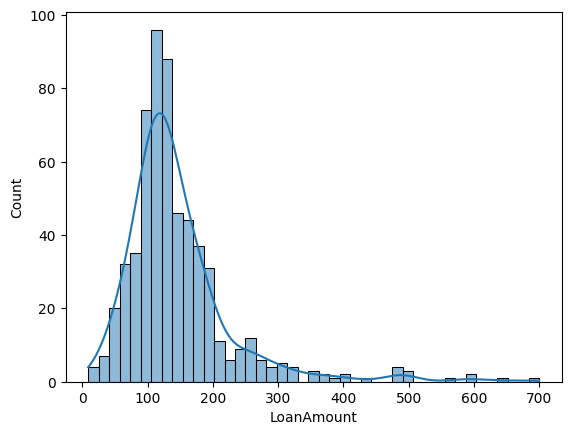

In [6]:
# Check out distributions of variables with missing values
import seaborn as sns

sns.histplot(data=df, x="LoanAmount", kde=True)

<Axes: xlabel='Loan_Amount_Term', ylabel='Count'>

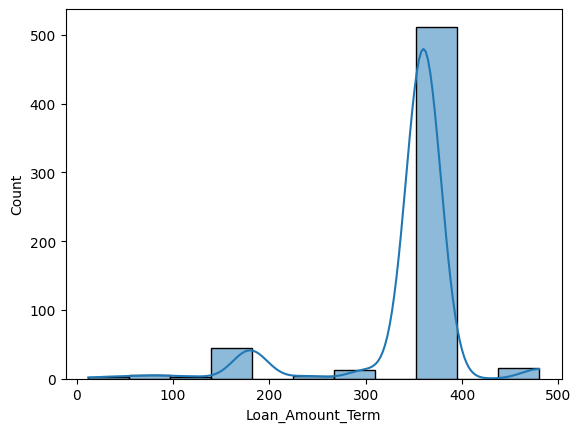

In [7]:
sns.histplot(data=df, x="Loan_Amount_Term", kde=True)

In [8]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

<Axes: xlabel='Credit_History', ylabel='count'>

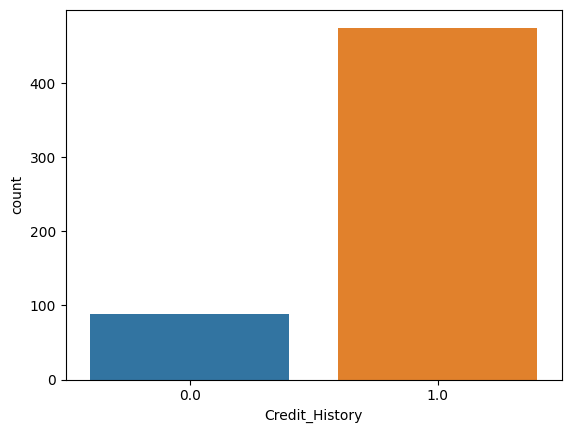

In [9]:
sns.countplot(data=df, x="Credit_History")

Determining the best strategy for missing value handling requires an understanding of each variable:
* LoanAmount
    * 3.6% null - low (not concerning)
    * Continuous
    * Right skewed
    
* Loan_Amount_Term
    * 2.3% null - low (not concerning)
    * Not continuous like expected, but rather 10 discrete bins
    * Left skewed
    
* Credit_History
    * 8.1% null - low/moderate (somewhat concerning)
    * Categorical binary
    * Greatly skewed to 1.0 (Credit history meets guidelines)

**LoanAmount** is skewed and continuous, so the median value will be used to impute missing values.
**Loan_Amount_Term** is skewed and appears discrete, so the modal value will be used to impute missing values.
**Credit_History** is binary, so the modal value will be used to impute missing values

In [10]:
# Impute missing vals with the median value
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

# Impute missing vals with the modal value
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [11]:
# Fix dtypes
df['ApplicantIncome'] = df['ApplicantIncome'].astype(float)
df['Credit_History'] = df['Credit_History'].astype(int)

In [12]:
# Validate missing value handling
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ApplicantIncome    614 non-null    float64
 1   CoapplicantIncome  614 non-null    float64
 2   LoanAmount         614 non-null    float64
 3   Loan_Amount_Term   614 non-null    float64
 4   Credit_History     614 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 24.1 KB


Prior to any further modification, the data needs to be split. To make sure that the dataset is representative the balance of the classes needs to be assessed.

#### Split
Splitting the dataset into train and test sets

In [13]:
# Check the balance of the classes
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

The dataset is clearly unbalanced so the train_test_split will have to be stratified.

In [14]:
X = df[features]
y = df['Loan_Status']

In [15]:
# Create a random and representative train/test split
from sklearn.model_selection import train_test_split

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

## 3. Data Exploration

### Distribution analysis

Study distribution of various variables

So far we know:
- LoanAmount is **right skewed**
- Loan_Amount_Term is **left skewed**
- Credit_History is **unbalanced** (Significantly more applicants with a credit history that meets guidelines than applicants with a credit history that does not)

Descriptive Stats:

In [16]:
X_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,491.000000,491.000000,491.000000,491.000000,491.000000
mean,5529.997963,1569.537271,146.523422,341.743381,0.863544
std,6457.784318,2789.523475,85.386044,65.107943,0.343622
min,210.000000,0.000000,9.000000,12.000000,0.000000
25%,2906.000000,0.000000,100.500000,360.000000,1.000000
50%,3859.000000,1032.000000,128.000000,360.000000,1.000000
75%,5825.000000,2241.000000,165.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


The distributions left to analyze with histograms are ApplicantIncome and CoapplicantIncome, as well as boxplots of all numerical features

#### Histograms:

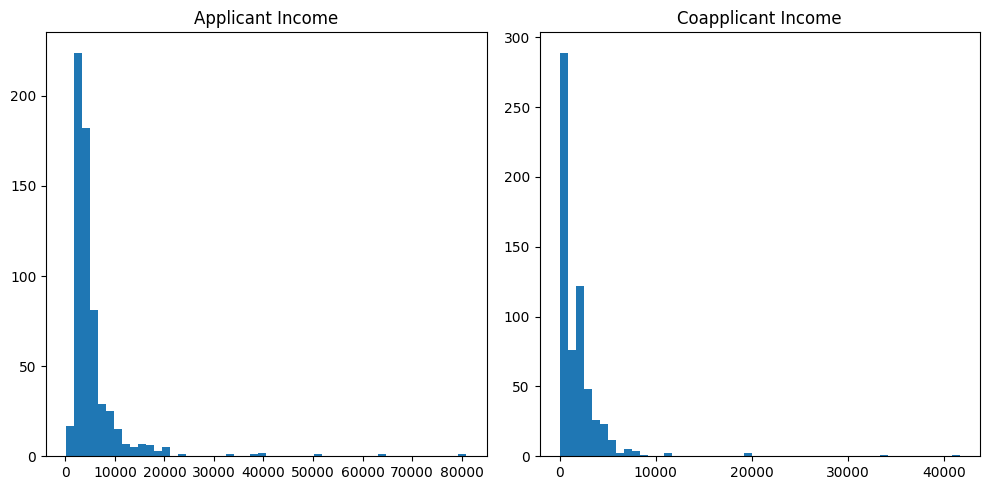

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].hist(df['ApplicantIncome'], bins=50)
axes[0].set_title('Applicant Income')

axes[1].hist(df['CoapplicantIncome'], bins=50)
axes[1].set_title('Coapplicant Income')

plt.tight_layout()
plt.show()

#### Boxplots:

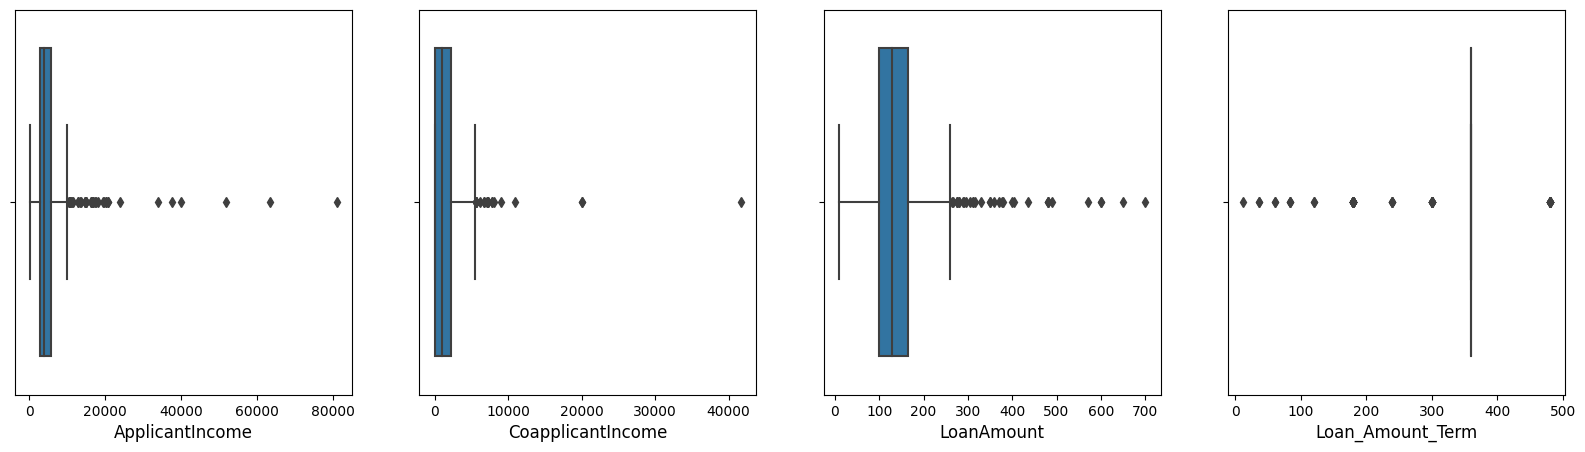

In [18]:
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

fig, axs = plt.subplots(ncols=4, figsize=(20,5))
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=X_train[feature], ax=axs[i])
    axs[i].set_xlabel(feature, fontsize=12)
plt.show()

ApplicantIncome and CoapplicantIncome are both right skewed distributions, as is typical of income data. The boxplots indicate many of the values in these distributions are extreme, however, these extreme values are not unreasonable. To get a better understanding of the extreme values they can be observed in the context of their records. 

In [19]:
# Display the 5 highest values in ApplicantIncome
print(X_train.nlargest(5, 'ApplicantIncome'))

# Display the 5 highest values in CoapplicantIncome
print(X_train.nlargest(5, 'CoapplicantIncome'))

# Display the 5 highest values in LoanAmount
print(X_train.nlargest(5, 'LoanAmount'))

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
409          81000.0                0.0       360.0             360.0   
333          63337.0                0.0       490.0             180.0   
171          51763.0                0.0       700.0             300.0   
155          39999.0                0.0       600.0             180.0   
443          37719.0                0.0       152.0             360.0   

     Credit_History  
409               0  
333               1  
171               1  
155               0  
443               1  
     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
600            416.0            41667.0       350.0             180.0   
417           1600.0            20000.0       239.0             360.0   
402           2500.0            20000.0       103.0             360.0   
9            12841.0            10968.0       349.0             360.0   
122           2137.0             8980.0       137.0             

Extreme Applicant incomes seem to not typically have Coapplicants. Extreme Coapplicant incomes typically accompany applicants with lower incomes, and in the case that the applicants income is also high, the LoanAmount is quite high. 

## 4. Feature Engineering

Modifying existing variables and creating new ones for analysis.

In [20]:
from scipy import stats

def shapiro_wilks(X, feature):
    stat, p = stats.shapiro(X[feature])
    
    print('Test statistic:', stat)
    print('p-value:', p)
    
    if p > 0.05:
        print(f'{feature} looks Gaussian (fail to reject H0)\n')
    else:
        print(f'{feature} does not look Gaussian (reject H0)\n')

In [21]:
#FIXME The Loan_Amount_Term should be handled seperately since it is discrete (Anderson-Darling or Kolmogorov-Smirnov).
for feature in numerical_features:
    shapiro_wilks(X_train, feature)

Test statistic: 0.45601606369018555
p-value: 5.231363479624297e-36
ApplicantIncome does not look Gaussian (reject H0)

Test statistic: 0.498565137386322
p-value: 5.980987577437023e-35
CoapplicantIncome does not look Gaussian (reject H0)

Test statistic: 0.7565665245056152
p-value: 2.7700502478701884e-26
LoanAmount does not look Gaussian (reject H0)

Test statistic: 0.4668487310409546
p-value: 9.582529646322328e-36
Loan_Amount_Term does not look Gaussian (reject H0)



With confirmation the continuous features are not from normal distributions, they will be log tranformed to attempt to make them more normal. Since the log transformation will not work on values equal to zero, the income and coapplicant income columns will be combined into one tot_income column before log transformation. The LoanAmount column will have 0 values imputed, since they don't make sense and it will allow for log transformation.

In [22]:
def incomeSum(X):
    X['tot_income'] = X['ApplicantIncome'] + X['CoapplicantIncome']

In [23]:
incomeSum(X_train)
incomeSum(X_test)

In [24]:
#FIXME the log_transform will be used on the test data so it shouldn't display those histplots \
# a new function can be created to wrap this function with histplot code, for use with training data specifically

def log_transform(X, feature):
    # Before transformation
    sns.histplot(X[feature], kde=True)
    plt.title("Before transformation")
    plt.show()
    shapiro_wilks(X, feature)
    
    # Tranformation
    X[feature + '_log'] = np.log(X[feature])
    
    # After tranformation
    sns.histplot(X[feature + '_log'], kde=True)
    plt.title("After transformation")
    plt.show()
    shapiro_wilks(X, f'{feature}_log')

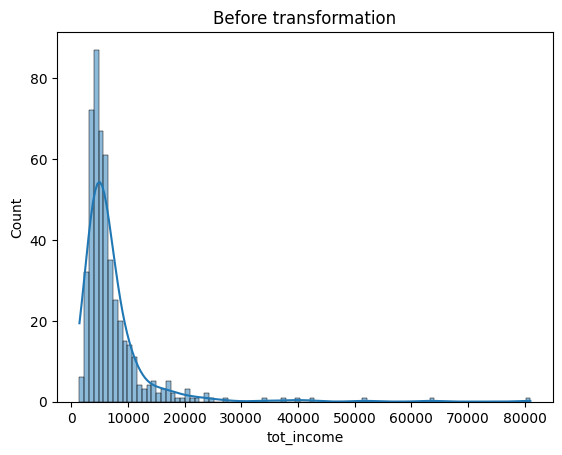

Test statistic: 0.5094125270843506
p-value: 1.143144608534414e-34
tot_income does not look Gaussian (reject H0)



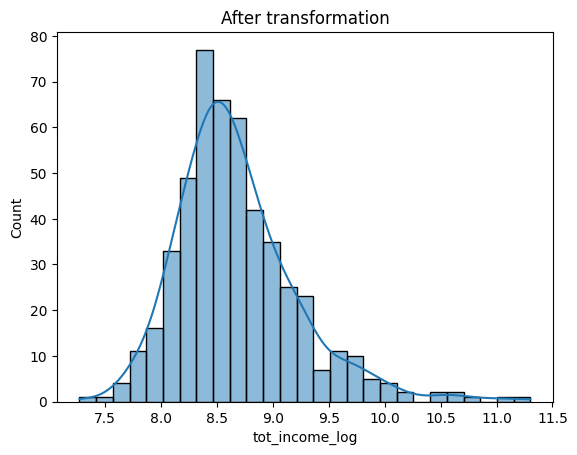

Test statistic: 0.9362315535545349
p-value: 1.200490173849239e-13
tot_income_log does not look Gaussian (reject H0)



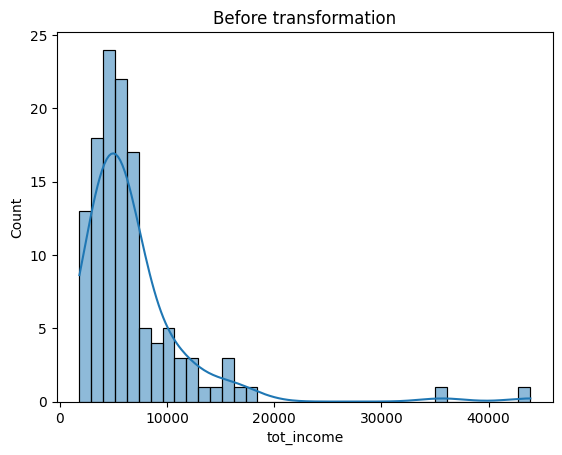

Test statistic: 0.6143962144851685
p-value: 1.7619009251361553e-16
tot_income does not look Gaussian (reject H0)



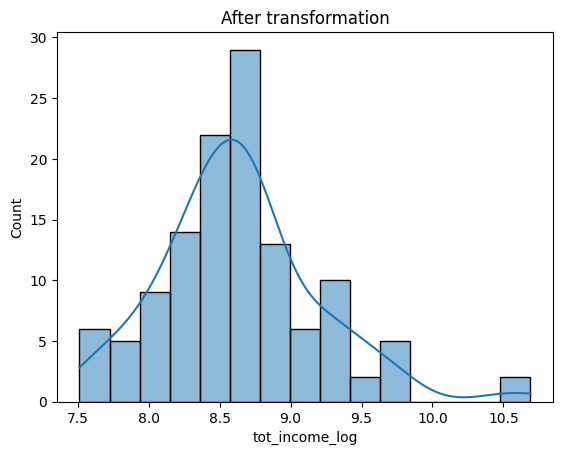

Test statistic: 0.962932825088501
p-value: 0.0018673872109502554
tot_income_log does not look Gaussian (reject H0)



In [25]:
log_transform(X_train, 'tot_income')
log_transform(X_test, 'tot_income')

In [26]:
# Impute LoanAmount 0 values to the median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(X_train['LoanAmount'][X_train['LoanAmount']!=0].values.reshape(-1,1))

def imputeLoanAmount(X):
    X['LoanAmount'] = imputer.transform(X['LoanAmount'].values.reshape(-1,1))

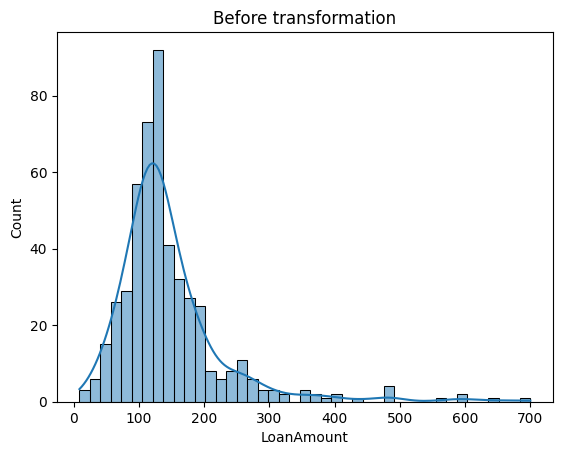

Test statistic: 0.7565665245056152
p-value: 2.7700502478701884e-26
LoanAmount does not look Gaussian (reject H0)



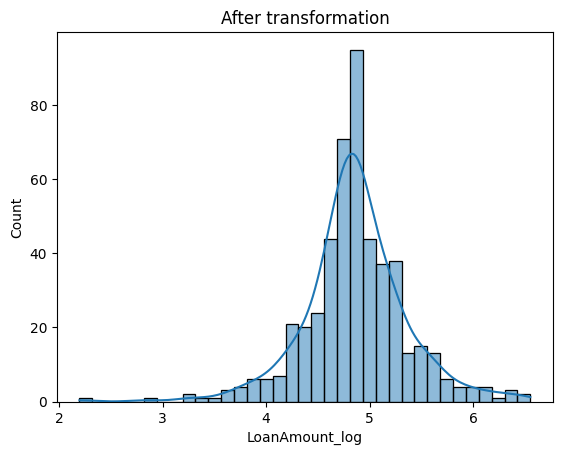

Test statistic: 0.9557762742042542
p-value: 5.770590255638197e-11
LoanAmount_log does not look Gaussian (reject H0)



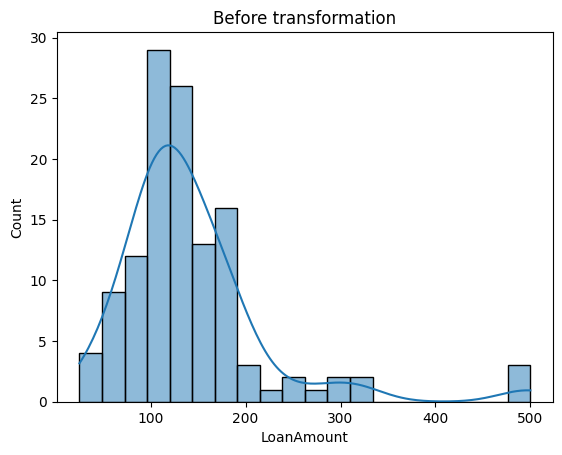

Test statistic: 0.7694320678710938
p-value: 1.2779191767287035e-12
LoanAmount does not look Gaussian (reject H0)



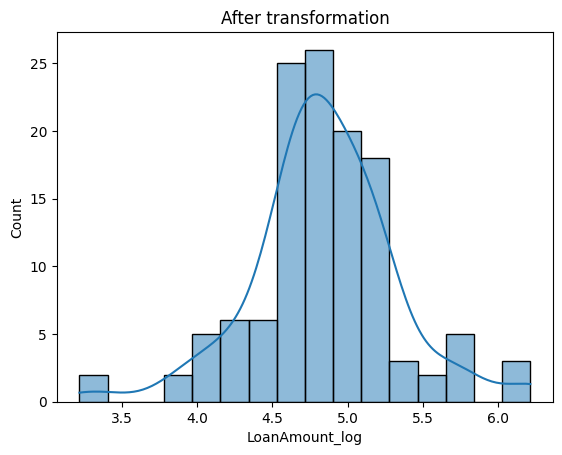

Test statistic: 0.9600013494491577
p-value: 0.0010685489978641272
LoanAmount_log does not look Gaussian (reject H0)



In [27]:
imputeLoanAmount(X_train)
imputeLoanAmount(X_test)

log_transform(X_train, 'LoanAmount')
log_transform(X_test, 'LoanAmount')

The normality testing still shows a none-gaussian distribution, but the histograms show that the features are closer to a normal distribution and the extremity of the outliers has been reduced, so this is still an improvement.

To prepare the discrete values in Loan_Amount_Term for modelling, they will be binned.

In [28]:
# bin Loan_Amount_Term into categories
def binLoan_Amount_Term(X):
    bins = [0, 200, 360, 600]
    labels = ['Short Term', 'Medium Term', 'Long Term']
    X['Loan_Amount_Term_Group'] = pd.cut(X['Loan_Amount_Term'], bins=bins, labels=labels, include_lowest=True)
    X['Loan_Amount_Term_Group'] = pd.Categorical(X['Loan_Amount_Term_Group'], categories=labels, ordered=True)

In [29]:
binLoan_Amount_Term(X_train)
binLoan_Amount_Term(X_test)

#### Preprocessing

In [30]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelBinarizer

# scale and encode the df for training
X_train_prepreprocessing = X_train.copy()
X_train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'tot_income'], axis = 1, inplace = True)
X_test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'tot_income'], axis = 1, inplace = True)

# encode categories
encoder = OrdinalEncoder()
encoder.fit(X_train[['Loan_Amount_Term_Group']])
X_train[['Loan_Amount_Term_Group']] = encoder.transform(X_train[['Loan_Amount_Term_Group']])
X_test[['Loan_Amount_Term_Group']] = encoder.transform(X_test[['Loan_Amount_Term_Group']])

# scale numerical
scaler = StandardScaler()
X_train[['tot_income_log', 'LoanAmount_log']] = scaler.fit_transform(X_train[['tot_income_log', 'LoanAmount_log']])
X_test[['tot_income_log', 'LoanAmount_log']] = scaler.transform(X_test[['tot_income_log', 'LoanAmount_log']])

# binarize target
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
y_train = y_train.ravel()

In [31]:
y_train[:5]

array([1, 1, 0, 0, 1])

In [32]:
X_train.head()

,Credit_History,tot_income_log,LoanAmount_log,Loan_Amount_Term_Group
154,1,-1.087150,-1.898096,1.0
239,1,-1.052939,-0.592937,1.0
448,0,-0.277576,0.299984,1.0
471,0,-0.637797,-0.266731,2.0
273,1,-0.354672,0.299984,1.0


## 5. Modelling

#### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Instantiate a logistic regression model
logreg = LogisticRegression()

# Perform 5-fold cross-validation on the training data
scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1')

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.86842105 0.87581699 0.88       0.8627451  0.8627451 ]
Mean cross-validation score: 0.8699456484348126


In [34]:
from sklearn.model_selection import GridSearchCV

# Optimize hyperparameters
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['liblinear', 'saga']}

lr = LogisticRegression(max_iter=10000)

grid_lr = GridSearchCV(lr, param_grid, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_lr.best_score_))

Best hyperparameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.87


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Final model

params = grid_lr.best_params_
final_model = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear')
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# calc metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.85
Precision: 0.83
Recall: 0.99
F1 Score: 0.90


#### XGBoost (WIP!)

In [ ]:
# import xboost as xgb

# # convert pandas DataFrames to xgb DMatrices
# dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
# dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# # Define hyperparameters
# params = {'objective': 'binary:logistic', 'tree_method': ''}

# n = 100
# xgb_model = xgb.train(
#     params = params,
#     dtrain = dtrain_reg,
#     num_boost_round = n
# )

In [ ]:
# # evaluate the model traditionally
# from sklearn.metrics import allthemclassificationmetrics

In [ ]:
# # evaluate with valiation sets during training
# evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]

# n = 1000
# xgb_model = xgb.train(
#     params=params,
#     dtrain=dtrain_reg,
#     num_boost_round=n,
#     evals=evals,
#     verbose_eval = 25
#     early_stopping_rounds = 20
# )

In [ ]:
# # evaluate our model with cross-validation
# params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
# n = 1000

# results = xgb.cv(
#     params,
#     dtrain_reg,
#     num_boost_round=n,
#     nfold=5,
#     early_stopping_rounds=20
# )
# results.head()

## 6. Using Pipeline
Develop the data prep, feature engineering, and modeling steps identified in EDA, into a Pipeline.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

#### Deployment test pipeline

In [ ]:
class RawFeats:
    def __init__(self, feats):
        self.feats = feats
        
    def fit(self, X, y=None):
        pass
    
    def transform(self, X, y=None):
        return X[self.feats]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
raw_feats = RawFeats()

In [ ]:
categorical_preprocessing = Pipeline([('ordinalEnc', OrdinalEncoder())])
numerical_preprocessing = Pipeline([('imputation', SimpleImputer())])

preprocess = ColumnTranformer([
    ('categorical_preprocessing', categorical_preprocessing, ['Loan_Amount_Term'])
    ('numerical_preprocessing', numerical_preprocessing, ['tot_income', 'LoanAmount'])
])

test_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression())
])

#### Full pipeline (WIP!)

In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.preprocessing import KBinsDiscretizer

# # define preprocessing steps for numeric features
# num_transformer = Pipeline(steps=[
#     ('income_combine', FunctionTransformer(np.log1p, validate=False)),
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# # define preprocessing steps for categorical features
# cat_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OrdinalEncoder())
# ])

# # combine preprocessing steps for all features
# preprocessor = ColumnTransformer([
#         ('num', num_transformer, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']),
#         ('cat', cat_transformer, ['Loan_Amount_Term'])
# ])

# # define the model
# model = LogisticRegression()

# # combine preprocessing and model into a pipeline
# pipe = Pipeline(steps=[('tot_income', FunctionTransformer(lambda X: X.assign(tot_income=X['ApplicantIncome'] + X['CoapplicantIncome']))), 
#     ('preprocessor', preprocessor),
#     ('discretizer', KBinsDiscretizer(n_bins=3, encode='ordinal')),
#     ('model', model)
# ])

# # define parameter grid for grid search
# param_grid = {
#     'model__C': [0.1, 1, 10],
# }

# # create a grid search object
# grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=5)

# # fit the grid search object to the data
# X = data.drop(['Loan_Status', 'Gender', 'Married', 'Dependents', 'Education', 'Property_Area', 'Loan_ID'], axis=1)
# y = target_transformer.fit_transform(data['Loan_Status'])
# grid_search.fit(X, y)

# # fit the final model with the best parameters on the entire dataset
# final_model = Pipeline(steps=[
#     ('tot_income', FunctionTransformer(lambda X: X.assign(tot_income=X['ApplicantIncome'] + X['CoapplicantIncome']))), 
#     ('preprocessor', preprocessor),
#     ('discretizer', KBinsDiscretizer(n_bins=3, encode='ordinal')),
#     ('model', GridSearchCV(
#         LogisticRegression(),
#         param_grid={
#             'C': [0.1, 1, 10],
#             'penalty': ['l1', 'l2']
#             'solver': ['liblinear', 'saga']
#         },
#         cv=5,
#         scoring='f1'
#     ))
# ])

# final_model.fit(X, y)

## 7. Deployment

Deploy the model to the cloud and test it.

In [ ]:
import pickle

pipeline.fit(df, df['Loan_Status'])
with open('../src/model.pkl', 'wb') as file:
    pickle.dump(test_pipeline, file)

In [ ]:
import requests

# Test the api
json_data = {}

URL = ''
r = requests.post(url = URL, json = json_data)
print(r.json())